<a href="https://colab.research.google.com/github/Sulfyy/SpaceTitanicML/blob/main/SpaceTitanic2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.3 MB/s eta 0:00:00


In [ ]:
# загрузка датасетов (можно скачать с Kaggle)

In [2]:
data=pd.read_csv('drive/MyDrive/Spaceship Titanic/train.csv')

In [3]:
X_test=pd.read_csv('drive/MyDrive/Spaceship Titanic/test.csv')

In [4]:
submission_id = X_test.PassengerId

In [5]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
#выделение целевой переменной

In [6]:
target=data['Transported']

In [ ]:
#разбиваем сложные столбцы на составные части

In [7]:
def split_feature(feature: str, new_features: list, sep: str) -> None:
    # Добавляем проверку наличия столбца
    if feature in data.columns:
        data[new_features] = data[feature].str.split(sep, expand=True)
    if feature in X_test.columns:
        X_test[new_features] = X_test[feature].str.split(sep, expand=True)

def drop_features(features: list) -> None:
    # Удаляем только существующие столбцы
    cols_to_drop = [f for f in features if f in data.columns]
    data.drop(cols_to_drop, axis=1, inplace=True)

    cols_to_drop = [f for f in features if f in X_test.columns]
    X_test.drop(cols_to_drop, axis=1, inplace=True)

def cast_feature(df, feature, to_type):
    if feature in df.columns:
        if to_type == 'float':
            df[feature] = pd.to_numeric(df[feature], errors='coerce').astype(float)
        elif to_type == 'int':
            df[feature] = pd.to_numeric(df[feature], errors='coerce').fillna(0).astype(int)
    return df

# Сначала разбиваем столбцы
split_feature('PassengerId', ['GroupId', 'IdWithinGroup'], '_')
split_feature('Cabin', ['Deck', 'Num', 'Side'], '/')

# Затем удаляем ненужные
drop_features(['Name', 'PassengerId', 'Cabin', 'IdWithinGroup', 'VIP'])

# Преобразуем типы
for feature in ['GroupId']:
    data = cast_feature(data, feature, 'float')
    X_test = cast_feature(X_test, feature, 'float')

In [8]:
for feature in ['Num']:
    cast_feature(data, feature, 'float')

In [9]:
for feature in ['CryoSleep']:
    data = cast_feature(data, feature, 'bool')


In [10]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,Deck,Num,Side
0,Europa,False,TRAPPIST-1e,39.0,0.0,0.0,0.0,0.0,0.0,False,1.0,B,0.0,P
1,Earth,False,TRAPPIST-1e,24.0,109.0,9.0,25.0,549.0,44.0,True,2.0,F,0.0,S
2,Europa,False,TRAPPIST-1e,58.0,43.0,3576.0,0.0,6715.0,49.0,False,3.0,A,0.0,S
3,Europa,False,TRAPPIST-1e,33.0,0.0,1283.0,371.0,3329.0,193.0,False,3.0,A,0.0,S
4,Earth,False,TRAPPIST-1e,16.0,303.0,70.0,151.0,565.0,2.0,True,4.0,F,1.0,S


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8492 non-null   object 
 1   CryoSleep     8476 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8494 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(8), object(5)
memory usage: 891.5+ KB


In [12]:
X_test.head()

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Deck,Num,Side
0,Earth,True,TRAPPIST-1e,27.0,0.0,0.0,0.0,0.0,0.0,13.0,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,0.0,9.0,0.0,2823.0,0.0,18.0,F,4,S
2,Europa,True,55 Cancri e,31.0,0.0,0.0,0.0,0.0,0.0,19.0,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,0.0,6652.0,0.0,181.0,585.0,21.0,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,10.0,0.0,635.0,0.0,0.0,23.0,F,5,S


In [13]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Destination   4185 non-null   object 
 3   Age           4186 non-null   float64
 4   RoomService   4195 non-null   float64
 5   FoodCourt     4171 non-null   float64
 6   ShoppingMall  4179 non-null   float64
 7   Spa           4176 non-null   float64
 8   VRDeck        4197 non-null   float64
 9   GroupId       4277 non-null   float64
 10  Deck          4177 non-null   object 
 11  Num           4177 non-null   object 
 12  Side          4177 non-null   object 
dtypes: float64(7), object(6)
memory usage: 434.5+ KB


In [ ]:
# заполняем пропущенные данные

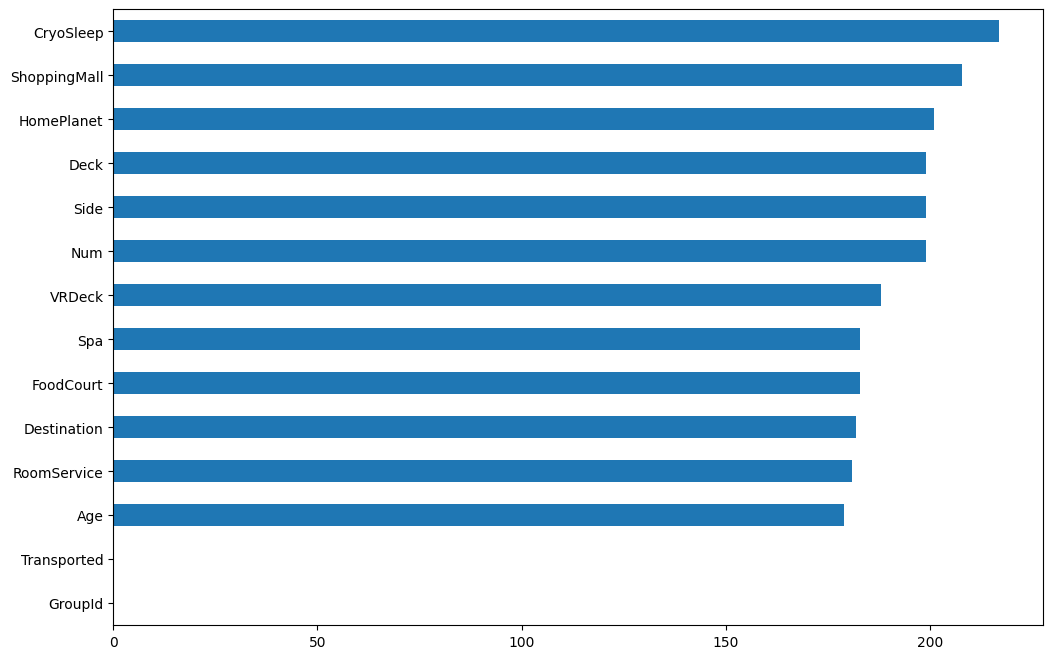

In [14]:
data.replace(" ", np.nan, inplace=True)
X_test.replace(" ", np.nan, inplace=True)
pd.DataFrame(data.isna().sum(), columns=["NaN Count"]) \
    .sort_values("NaN Count") \
    .plot(kind="barh", legend=False, figsize=(12, 8));

In [15]:
def count_na_values(df: pd.DataFrame) -> pd.DataFrame:
    # количество пропусков и их %
    mis_val = df.isna().sum()

    mis_val_percent = 100 * df.isnull().sum() / len(df)

    missing_values = pd.DataFrame()
    missing_values[['count missing values', '% of missing values']]= pd.concat([mis_val, mis_val_percent], axis=1)
    return missing_values


count_na_values(data)

,count missing values,% of missing values
HomePlanet,201,2.312205
CryoSleep,217,2.496261
Destination,182,2.093639
Age,179,2.059128
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142
VRDeck,188,2.162660
Transported,0,0.000000


In [ ]:
# заполняем пропущенные данные столбца 'CryoSleep' на основе анализа расходов пассажира

In [16]:
def impute_cryo_sleep(df: pd.DataFrame) -> None:
    df.loc[
        ((df['RoomService'] == 0.0) | df['RoomService'].isnull()) &
        ((df['FoodCourt'] == 0.0) | df['FoodCourt'].isnull()) &
        ((df['ShoppingMall'] == 0.0) | df['ShoppingMall'].isnull()) &
        ((df['Spa'] == 0.0) | df['Spa'].isnull()) &
        ((df['VRDeck'] == 0.0) | df['VRDeck'].isnull()) &
        (df['CryoSleep'].isnull()),
        'CryoSleep'
    ] = True

    df.loc[
        ((df['RoomService'] > 0.0) |
        (df['FoodCourt'] > 0.0) |
        (df['ShoppingMall'] > 0.0) |
        (df['Spa'] > 0.0) |
        (df['VRDeck'] > 0.0)) & (df['CryoSleep'].isnull()),
        'CryoSleep'
    ] = False


impute_cryo_sleep(data)
impute_cryo_sleep(X_test)

In [17]:
# анализируем соотношения между различными столбцами данных и в соответствии с результатами заполняем пропуски

In [17]:
home_planet_deck = data.groupby(['HomePlanet', 'Deck']).size().unstack().fillna(0)
home_planet_deck

Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.0,0.0,0.0,0.0,395.0,1614.0,2498.0,0.0
Europa,252.0,766.0,734.0,186.0,128.0,0.0,0.0,4.0
Mars,0.0,0.0,0.0,282.0,330.0,1110.0,0.0,0.0


In [18]:
home_planet_num = data.groupby(['HomePlanet', 'Num']).size().unstack().fillna(0)
home_planet_num

Num,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,1828.0,1829.0,1834.0,1841.0,1846.0,1863.0,1871.0,1872.0,1878.0,1888.0
HomePlanet,,,,,,,,,,,,,,,,,,,,,
Earth,10.0,4.0,4.0,4.0,2.0,1.0,4.0,1.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Europa,5.0,9.0,6.0,8.0,4.0,8.0,6.0,7.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Mars,1.0,2.0,1.0,3.0,1.0,4.0,1.0,1.0,3.0,3.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0


In [19]:
home_planet_side = data.groupby(['HomePlanet', 'Side']).size().unstack().fillna(0)
home_planet_side

Side,P,S
HomePlanet,,
Earth,2270,2237
Europa,955,1115
Mars,888,834


In [20]:
def impute_home_planet_by_deck(df: pd.DataFrame) -> None:
    df.loc[
        (df['Deck'] == 'G') & (df['HomePlanet'].isnull()),
        'HomePlanet'
    ] = 'Earth'

    europa_decks = ['A', 'B', 'C', 'T']
    df.loc[
        (df['Deck'].isin(europa_decks)) & (df['HomePlanet'].isnull()),
        'HomePlanet'
    ] = 'Europa'


impute_home_planet_by_deck(data)
impute_home_planet_by_deck(X_test)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8584 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8494 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(8), object(5)
memory usage: 891.5+ KB


In [22]:
def impute_home_planet_by_num(df: pd.DataFrame) -> None:
    df.loc[
        (df['Deck'] > '1750.0') & (df['HomePlanet'].isnull()),
        'HomePlanet'
    ] = 'Mars'




impute_home_planet_by_num(data)
impute_home_planet_by_num(X_test)

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8687 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8494 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(8), object(5)
memory usage: 891.5+ KB


In [24]:
home_planet_deck = data.groupby(
    ['HomePlanet', 'Deck']
).size().unstack().fillna(0)

earth = home_planet_deck.loc['Earth']
earth_proba = list(earth / sum(earth))

europa = home_planet_deck.loc['Europa']
europa_proba = list(europa / sum(europa))

mars = home_planet_deck.loc['Mars']
mars_proba = list(mars / sum(mars))

decks = data['Deck'].unique()
deck_values = sorted(decks[~pd.isnull(decks)]) #['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
planet_proba = dict(
    zip(['Earth', 'Mars', 'Europa'], [earth_proba, mars_proba, europa_proba])
)

np.random.seed(0)


def impute_deck_by_home_planet(df: pd.DataFrame) -> None:
    for planet in planet_proba.keys():
        planet_null_decks_shape = df.loc[
            (df['HomePlanet'] == planet) & (df['Deck'].isnull()),
            'Deck'
        ].shape[0]

        df.loc[
            (df['HomePlanet'] == planet) & (df['Deck'].isnull()),
            'Deck'
        ] = np.random.choice(deck_values, planet_null_decks_shape, p=planet_proba[planet])


impute_deck_by_home_planet(data)
impute_deck_by_home_planet(X_test)

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8687 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8687 non-null   object 
 12  Num           8494 non-null   float64
 13  Side          8494 non-null   object 
dtypes: bool(1), float64(8), object(5)
memory usage: 891.5+ KB


In [26]:
data=data.drop(['Num'], axis=1)

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8687 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8511 non-null   object 
 3   Age           8514 non-null   float64
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8687 non-null   object 
 12  Side          8494 non-null   object 
dtypes: bool(1), float64(7), object(5)
memory usage: 823.6+ KB


In [28]:
count_na_values(data)

,count missing values,% of missing values
HomePlanet,6,0.069021
CryoSleep,0,0.000000
Destination,182,2.093639
Age,179,2.059128
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142
VRDeck,188,2.162660
Transported,0,0.000000


In [29]:
X_test=X_test.drop(['Num'], axis=1)

In [30]:
def impute_age_by_planet(df: pd.DataFrame) -> None:
    for planet in ['Europa', 'Earth', 'Mars']:
        planet_median = df[df['HomePlanet'] == planet]['Age'].median()
        df.loc[
            (df['Age'].isnull()) & (df['HomePlanet'] == planet),
            'Age'
        ] = planet_median


impute_age_by_planet(data)
impute_age_by_planet(X_test)

In [31]:
count_na_values(data)

,count missing values,% of missing values
HomePlanet,6,0.069021
CryoSleep,0,0.000000
Destination,182,2.093639
Age,0,0.000000
RoomService,181,2.082135
FoodCourt,183,2.105142
ShoppingMall,208,2.392730
Spa,183,2.105142
VRDeck,188,2.162660
Transported,0,0.000000


In [ ]:
# заполняем пропущенные значения (NaN) в числовых и категориальных столбцах с использованием стратегий median (медиана) для чисел и most_frequent (самое частое значение) для категорий.

In [32]:

from sklearn.impute import SimpleImputer

# Определение числовых и категориальных столбцов
numerical_columns = data.select_dtypes(include=['number']).columns
categorical_columns = X_test.select_dtypes(exclude=['number']).columns

# Обработка числовых столбцов
num_imputer = SimpleImputer(strategy='median')
data[numerical_columns] = num_imputer.fit_transform(data[numerical_columns])
X_test[numerical_columns] = num_imputer.transform(X_test[numerical_columns])

# Обработка категориальных столбцов
cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_columns] = cat_imputer.fit_transform(data[categorical_columns])
X_test[categorical_columns] = cat_imputer.transform(X_test[categorical_columns])

In [33]:
count_na_values(data)

,count missing values,% of missing values
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0
Transported,0,0.0


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   object 
 2   Destination   8693 non-null   object 
 3   Age           8693 non-null   float64
 4   RoomService   8693 non-null   float64
 5   FoodCourt     8693 non-null   float64
 6   ShoppingMall  8693 non-null   float64
 7   Spa           8693 non-null   float64
 8   VRDeck        8693 non-null   float64
 9   Transported   8693 non-null   bool   
 10  GroupId       8693 non-null   float64
 11  Deck          8693 non-null   object 
 12  Side          8693 non-null   object 
dtypes: bool(1), float64(7), object(5)
memory usage: 823.6+ KB


In [35]:
count_na_values(X_test)

,count missing values,% of missing values
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0
VRDeck,0,0.0
GroupId,0,0.0


In [36]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4277 non-null   object 
 1   CryoSleep     4277 non-null   object 
 2   Destination   4277 non-null   object 
 3   Age           4277 non-null   float64
 4   RoomService   4277 non-null   float64
 5   FoodCourt     4277 non-null   float64
 6   ShoppingMall  4277 non-null   float64
 7   Spa           4277 non-null   float64
 8   VRDeck        4277 non-null   float64
 9   GroupId       4277 non-null   float64
 10  Deck          4277 non-null   object 
 11  Side          4277 non-null   object 
dtypes: float64(7), object(5)
memory usage: 401.1+ KB


In [ ]:
# в результате выполнения кода выше мы избавились от пропущенных данных

In [ ]:
# логарифмируем числовые данные для уменьшения диапазона и повышения устойчивости модели

In [37]:
def log_transform_data(df: pd.DataFrame) -> None:
    for col in numerical_columns[1:-1]:
        df[col] = np.log(1 + df[col])


log_transform_data(data)
log_transform_data(X_test)

In [38]:
X_test

,HomePlanet,CryoSleep,Destination,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,GroupId,Deck,Side
0,Earth,True,TRAPPIST-1e,27.0,0.000000,0.000000,0.000000,0.000000,0.000000,13.0,G,S
1,Earth,False,TRAPPIST-1e,19.0,0.000000,2.302585,0.000000,7.945910,0.000000,18.0,F,S
2,Europa,True,55 Cancri e,31.0,0.000000,0.000000,0.000000,0.000000,0.000000,19.0,C,S
3,Europa,False,TRAPPIST-1e,38.0,0.000000,8.802823,0.000000,5.204007,6.373320,21.0,C,S
4,Earth,False,TRAPPIST-1e,20.0,2.397895,0.000000,6.455199,0.000000,0.000000,23.0,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,0.000000,0.000000,0.000000,0.000000,0.000000,9266.0,G,S
4273,Earth,False,TRAPPIST-1e,42.0,0.000000,6.742881,2.890372,2.397895,4.976734,9269.0,G,S
4274,Mars,True,55 Cancri e,27.0,0.000000,0.000000,0.000000,0.000000,0.000000,9271.0,D,P
4275,Europa,False,TRAPPIST-1e,32.0,0.000000,7.893945,0.000000,0.000000,6.261492,9273.0,D,P


In [39]:
data['CryoSleep'] = data['CryoSleep'].astype(int)
X_test['CryoSleep'] = X_test['CryoSleep'].astype(int)

In [41]:
# кодируем категориальные столбцы для корректной работы моделей ML (One-Hot Encoding)

In [40]:
data = pd.get_dummies(data)
X_test = pd.get_dummies(X_test)

In [41]:
data

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,0,39.0,0.000000,0.000000,0.000000,0.000000,0.000000,False,1.0,False,...,False,True,False,False,False,False,False,False,True,False
1,0,24.0,4.700480,2.302585,3.258097,6.309918,3.806662,True,2.0,True,...,False,False,False,False,False,True,False,False,False,True
2,0,58.0,3.784190,8.182280,0.000000,8.812248,3.912023,False,3.0,False,...,True,False,False,False,False,False,False,False,False,True
3,0,33.0,0.000000,7.157735,5.918894,8.110728,5.267858,False,3.0,False,...,True,False,False,False,False,False,False,False,False,True
4,0,16.0,5.717028,4.262680,5.023881,6.338594,1.098612,True,4.0,True,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,0,41.0,0.000000,8.827615,0.000000,7.404888,4.317488,False,9276.0,False,...,True,False,False,False,False,False,False,False,True,False
8689,1,18.0,0.000000,0.000000,0.000000,0.000000,0.000000,False,9278.0,True,...,False,False,False,False,False,False,True,False,False,True
8690,0,26.0,0.000000,0.000000,7.535297,0.693147,0.000000,True,9279.0,True,...,False,False,False,False,False,False,True,False,False,True
8691,0,32.0,0.000000,6.956545,0.000000,5.869297,8.082093,False,9280.0,False,...,False,False,False,False,True,False,False,False,False,True


In [42]:
data = data.drop(columns=['Transported'], errors='ignore')

In [43]:
y_train=target.astype(int)

In [44]:
y_train

,Transported
0,0
1,1
2,0
3,0
4,1
...,...
8688,0
8689,0
8690,1
8691,0


In [ ]:
# для автоматического подбора оптимальных гиперпараметров для CatBoost инсталлируем optuna-integration[catboost]

In [45]:
!pip install optuna-integration[catboost]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python

In [ ]:
# оптимизируем параметры для модели CatBoostClassifier для максимизации accuracy

In [82]:
from catboost import CatBoostClassifier
!pip install optuna
import optuna
from optuna.integration import CatBoostPruningCallback

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")

optuna.logging.disable_default_handler()

best_trials = pd.DataFrame(
columns=[
    'objective',
    'colsample_bylevel',
    'depth',
    'boosting_type',
    'bootstrap_type',
    'best_value'
    ]
)
def objective(trial: optuna.Trial) -> float:
    _X_train, X_valid, _y_train, y_valid = train_test_split(
        data, y_train, test_size=0.25 #y_train, test_size=0.25
    )

    params = {
        'objective': trial.suggest_categorical(
            'objective',
            ['Logloss', 'CrossEntropy']
        ),
        'colsample_bylevel': trial.suggest_float(
            'colsample_bylevel',
            0.01,
            0.1,
            log=True
        ),
        'depth': trial.suggest_int(
            'depth',
            1,
            12
        ),
        'boosting_type': trial.suggest_categorical(
            'boosting_type',
            ['Ordered', 'Plain']
        ),
        'bootstrap_type': trial.suggest_categorical(
            'bootstrap_type',
            ['Bayesian', 'Bernoulli', 'MVS']
        ),
        'used_ram_limit': '8gb',
        'eval_metric': 'Accuracy',
        'logging_level': 'Silent',
        'random_seed': 21
    }

    if params['bootstrap_type'] == 'Bayesian':
        params['bagging_temperature'] = trial.suggest_float(
            'bagging_temperature', 0, 10
        )

    clf = CatBoostClassifier(**params)
    pruning_callback = CatBoostPruningCallback(trial, 'Accuracy')

    clf.fit(
        _X_train,
        _y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=False,
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    pruning_callback.check_pruned()

    predictions = clf.predict(X_valid)
    prediction_labels = np.rint(predictions)
    accuracy = accuracy_score(y_valid, prediction_labels)

    return accuracy


studies = 1
trials = 100
for n in range(studies):
    study = optuna.create_study(
        pruner=optuna.pruners.MedianPruner(n_warmup_steps=5),
        #pruner=optuna.pruners.HyperbandPruner(),
        direction='maximize'
    )
    study.optimize(objective, n_trials=trials, timeout=600)

    print(f'best value = {study.best_value}')

    trial = study.best_trial
    for k, v in trial.params.items():
        print(f'{k}: {v}')

    best_trials.loc[n] = study.best_trial.params
    best_trials['best_value'].loc[n] = study.best_value
    best_trial = best_trials.sort_values('best_value', ascending=False).loc[0]


clf = CatBoostClassifier(**best_trial[:-1], logging_level='Silent', random_seed=21)
clf.fit(data, y_train.astype(int))

predicted = clf.predict(X_test)
best_trial = best_trials.sort_values('best_value', ascending=False).loc[0]


clf = CatBoostClassifier(**best_trial[:-1], logging_level='Silent', random_seed=21)
clf.fit(data, y_train.astype(int))

predicted = clf.predict(X_test) # Лучшие параметры из Optuna
best_params = {
    'objective': 'Logloss',
    'colsample_bylevel': 0.07256688643189559,
    'depth': 12,
    'boosting_type': 'Ordered',
    'bootstrap_type': 'Bernoulli',
    'eval_metric': 'Accuracy',
    'logging_level': 'Silent',
    'random_seed': 21
}

# Инициализация и обучение модели
clf = CatBoostClassifier(**best_params)
clf.fit(data, y_train.astype(int))

# Предсказание на тестовых данных
predicted = clf.predict(X_test)

best value = 0.8298068077276909
objective: Logloss
colsample_bylevel: 0.09006822065158687
depth: 11
boosting_type: Plain
bootstrap_type: Bayesian
bagging_temperature: 0.5063828186934006


In [51]:
print(f"Лучшая accuracy: {study.best_value}")

Лучшая accuracy: 0.8390064397424103


In [ ]:
# обучение модели CatBoostClassifier и предсказание на тестовом датасете (небольшая отладка при этом)

In [52]:

missing_cols = set(data.columns) - set(X_test.columns)

for col in missing_cols:
    X_test[col] = 0
X_test = X_test.drop(columns=['Transported_False', 'Transported_True'], errors='ignore') # Удаляем целевую, если она случайно попала в тест

In [53]:
X_test = X_test.drop(columns=['Transported_False', 'Transported_True'], errors='ignore')


X_test['Transported_False'] = 0
X_test['Transported_True'] = 0

In [54]:
data = data.drop(columns=['Transported_False', 'Transported_True'], errors='ignore')


data['Transported_False'] = 0
data['Transported_True'] = 0

In [55]:
print("Столбцы в data:", data.columns.tolist())
print("Столбцы в X_test:", X_test.columns.tolist())

Столбцы в data: ['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S', 'Transported_False', 'Transported_True']
Столбцы в X_test: ['CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'GroupId', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Side_P', 'Side_S', 'Transported_False', 'Transported_True']


In [56]:
best_trial = best_trials.sort_values('best_value', ascending=False).loc[0]


clf = CatBoostClassifier(**best_trial[:-1], logging_level='Silent', random_seed=21)
clf.fit(data, y_train.astype(int))

predicted = clf.predict(X_test)

In [57]:
save_submission = True

if save_submission:
    sub = pd.DataFrame()
    sub['PassengerId'] = pd.read_csv('drive/MyDrive/Spaceship Titanic/test.csv')['PassengerId']
    sub['Transported'] = pd.Series(predicted).astype(bool)
    sub.to_csv('drive/MyDrive/submission/Spaceship_Titanic_GBopt3.csv', index=False)

In [62]:
# алгоритм случайного леса для определения важности признаков

In [58]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [59]:
X_train=data

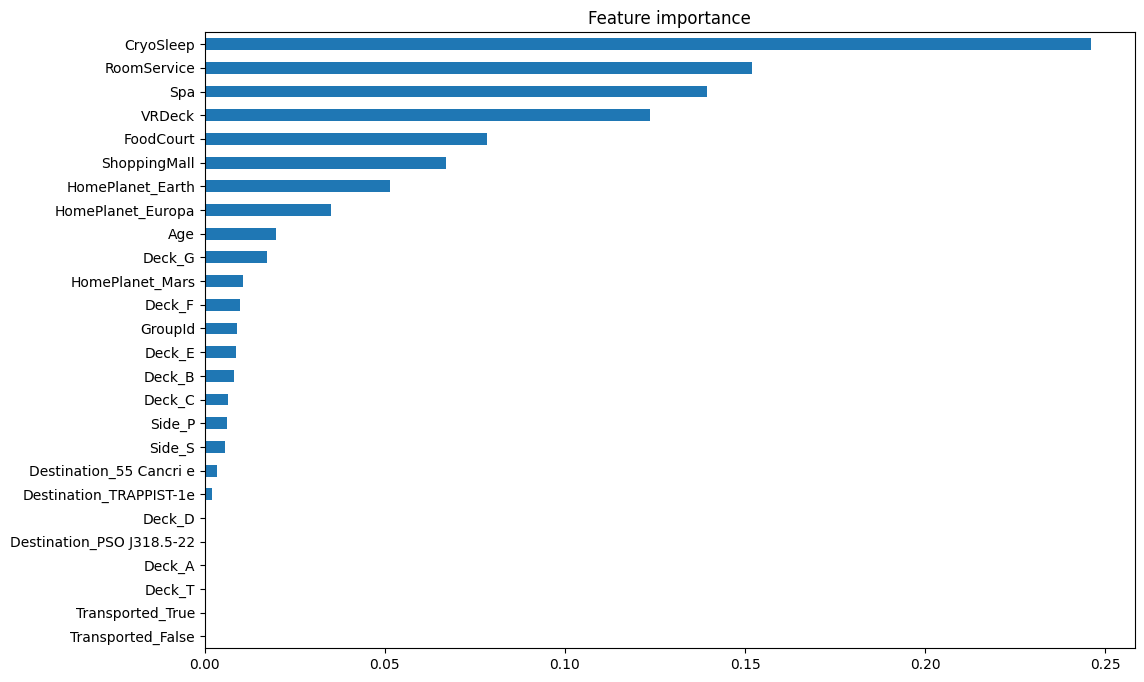

In [60]:
clf = RandomForestClassifier(n_estimators=1000, min_impurity_decrease=0.001)
clf.fit(X_train, y_train)
pd.DataFrame(clf.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

In [ ]:
# алгоритм решающих деревьев

In [61]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

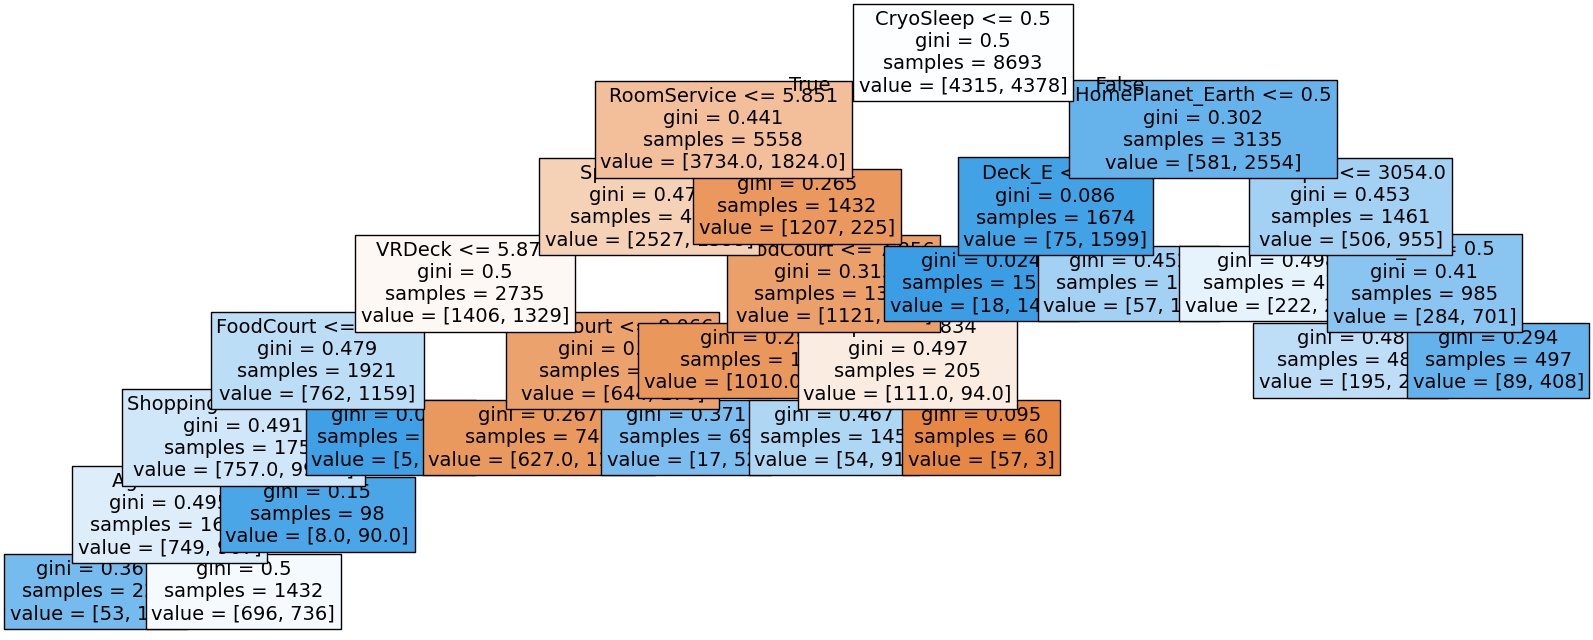

In [62]:
clf = DecisionTreeClassifier(min_impurity_decrease=0.002)
clf.fit(X_train, y_train)
plt.figure(figsize=(20, 8))
plot_tree(clf, fontsize=14, feature_names=X_train.columns, filled=True)
plt.show()

In [ ]:
# преобразуем коррелированные признаки в ортогональные (независимые) компоненты, устраняя мультиколлинеарность, а также пытаемся увидеть разделимость классов

In [63]:
from sklearn.decomposition import PCA

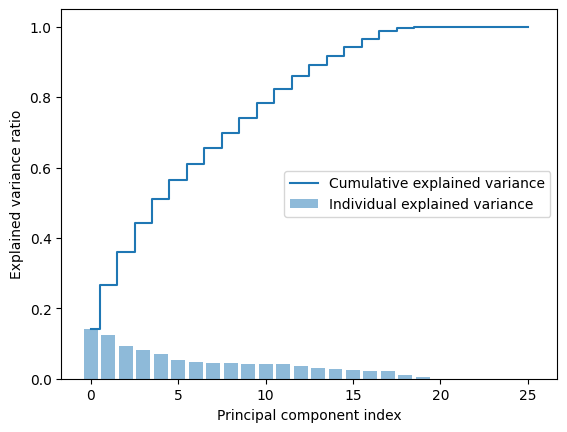

In [64]:
X_train_std = StandardScaler().fit_transform(X_train)
pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align="center", label="Individual explained variance")
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where="mid", label="Cumulative explained variance")
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal component index")
plt.legend(loc="best")
plt.show()

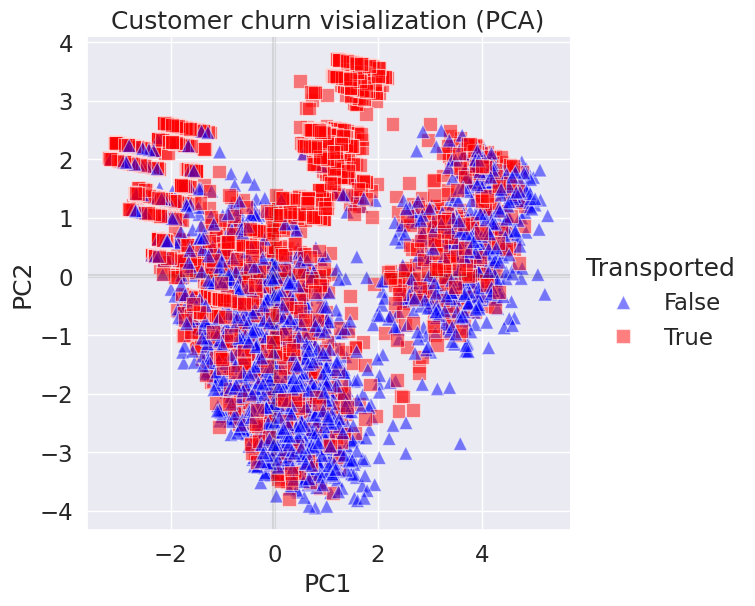

In [65]:
pca = PCA(n_components=2)
pca.fit(X_train_std)
x0, x1 = pca.components_
sns.set(font_scale=1.5)
y = y_train.map({0: False, 1: True})
fig = sns.pairplot(data=pd.concat([pd.DataFrame(data=X_train_std @ np.stack([x0, x1]).T, columns=["PC1", "PC2"]), y], axis=1),
                   x_vars="PC1",
                   y_vars="PC2",
                   hue="Transported",
                   markers=('^', 's'),
                   palette=["blue", "red"],
                   plot_kws={'s': 100, 'alpha': 0.5},
                   height=6)
fig.set(title="Customer churn visialization (PCA)")
fig.axes[0][0].axhline(y=0, color='black', lw=3, alpha=0.1)
fig.axes[0][0].axvline(x=0, color='black', lw=3, alpha=0.1);

In [ ]:
# обучаем алгоритм логистической регрессии

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
from sklearn.metrics import accuracy_score

In [68]:
%%time
PARAMS = {
    "model__C": [1.734],  # np.arange(0.001, 100, 0.001)
}
clf = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(penalty="l1", solver="saga", max_iter=1000, random_state=42)),
])
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="accuracy",
    n_jobs=1,
    cv=10,
    refit=True,
)
logreg = grid_search.fit(X_train, y_train)

CPU times: user 22 s, sys: 31 ms, total: 22 s
Wall time: 22.2 s


In [69]:
print(f"best score: {logreg.best_score_}")
print(f"best params: {logreg.best_params_}")

best score: 0.7771805351639485
best params: {'model__C': 1.734}


In [ ]:
# алгоритм ближайших соседей

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [71]:
PARAMS = {
    "model__n_neighbors": [44],  # range(1, 100),
    "model__metric": ["manhattan"],  # ["cityblock", "cosine", "euclidean", "l1", "l2", "manhattan", "nan_euclidean"],
}

clf =  Pipeline(steps=[

    ("model", KNeighborsClassifier()),
])

grid_search = GridSearchCV(
    estimator=clf,
    param_grid=PARAMS,
    scoring="accuracy",
    n_jobs=1,
    cv=10,
    refit=True,
    error_score='raise'
)
knn = grid_search.fit(X_train, y_train)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7df37b703a60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

In [72]:
print(f"best score: {knn.best_score_}")
print(f"best params: {knn.best_params_}")

best score: 0.39869105723317855
best params: {'model__metric': 'manhattan', 'model__n_neighbors': 44}


In [ ]:
Random Forest

In [73]:
PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [18],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="accuracy", cv=5)
rf = grid_search.fit(X_train, y_train);

In [74]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.7843147557125473
Best params: {'min_samples_leaf': 18, 'min_samples_split': 9}


In [81]:
Stacking

NameError: name 'Stacking' is not defined

In [ ]:
from sklearn.ensemble import StackingClassifier

In [81]:

# Инициализация моделей с безопасными параметрами
logreg = LogisticRegression(max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# CatBoost с отключенным многопоточением внутри модели
catboost = CatBoostClassifier(
    logging_level='Silent',
    iterations=100,
    random_seed=42,
    thread_count=1,
    task_type='CPU'
)

# Мета-модель с аналогичными настройками
meta = CatBoostClassifier(
    logging_level='Silent',
    iterations=100,
    random_seed=42,
    thread_count=1,
    task_type='CPU'
)

# StackingClassifier с отключенным параллелизмом
stacking = StackingClassifier(
    estimators=[
        ("logreg", logreg),
        ("rf", rf),
        ("catboost", catboost)
    ],
    final_estimator=meta,
    n_jobs=1,
    cv=5
)

# Оценка модели через кросс-валидацию
cv_scores = cross_val_score(stacking, X_train, y_train, cv=5, scoring='accuracy')
print(f"Результаты CV: {cv_scores}")
print(f"Средняя accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Финальное обучение
print("Обучение финальной модели на всех данных...")
stacking.fit(X_train, y_train)





Результаты CV: [0.77803335 0.77803335 0.80276021 0.80782509 0.79344074]
Средняя accuracy: 0.7920 ± 0.0123
Обучение финальной модели на всех данных...


StackingClassifier(cv=5,
                   estimators=[('logreg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x7df37bbb8cd0>)],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7df37bbb8610>,
                   n_jobs=1)

In [ ]:
# Предсказания

In [ ]:
best_model=

predictions =best_model.predict_proba(X_test)[:, 1]
n_predictions = (predictions > 0.5).astype(bool)

In [ ]:
# Сохранение в CSV для соревнований
save_submission = True
if save_submission:
    sub = pd.DataFrame()
    sub['PassengerId'] = pd.read_csv('drive/MyDrive/Spaceship Titanic/test.csv')['PassengerId']
    sub['Transported'] = pd.Series(n_predictions)
    sub.to_csv('drive/MyDrive/submission/Spaceship_Titanic_STopt.csv', index=False)